<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD;
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2023-AC215/' target='_blank'><strong><font color="#A41034">AC215: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#A41034">Tutorial - Dask</font>**

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**<br/>
Pavlos Protopapas

<hr style="height:2pt">

## **<font color="#A41034">Tutorial Outline</font>**

## **Learning Objectives**

By the end of this notebook, you should be able to:
* Familarize with Dask API
* Use Dask to compute dataset metrics


## **Tutorial Content**

- Download & preview data
- Introduction to Dask
- Visualizing DAGs
- Compute dataset metrics


## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab**

1) Select "File" menu and pick "Save a copy in Drive"   

**Imports**

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.utils import to_categorical
# from tensorflow.python.keras import backend as K
# from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Dask
import dask
import dask.dataframe as dd
import dask.delayed as delayed
from dask.diagnostics import ProgressBar

# Colab auth
from google.colab import auth
from google.cloud import storage

**Verify Setup**

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.13.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Thu Sep 21 20:39:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    51W / 400W |    703MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this lab

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

## **<font color="#A41034">Dataset</font>**



#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/mushrooms_3_labels.zip", base_path="datasets", extract=True)
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/Parking_Violations_Issued_-_Fiscal_Year_2017.csv.zip",
              base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.8531376361846924


## **<font color="#A41034">Introduction to Dask</font>**


### **Load Data**

Read data into a dataframe using dask API

In [ ]:
# parking_violation_csv = os.path.join("datasets","Parking_Violations_Issued_-_Fiscal_Year_2017.csv")
# df = pd.read_csv(parking_violation_csv)

# print("Shape:",df.shape)
# print(df.head())

In [ ]:
parking_violation_csv = os.path.join("datasets","Parking_Violations_Issued_-_Fiscal_Year_2017.csv")

# read data using DataFrame API
#df = dd.read_csv(parking_violation_csv) # , blocksize=640000000)
df = dd.read_csv(parking_violation_csv,dtype={'House Number': 'object','Time First Observed': 'object'})

print("Shape:", df.shape)
df

Shape: (Delayed('int-23bca115-7ebd-4dfe-a6f2-f4dcddc9ccb1'), 43)


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
npartitions=32,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,int64,object,object,object,int64,int64,int64,int64,float64,int64,int64,int64,object,object,object,object,object,object,object,object,object,int64,int64,object,object,object,object,object,object,float64,int64,object,int64,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
df.shape[0].compute()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


10803028

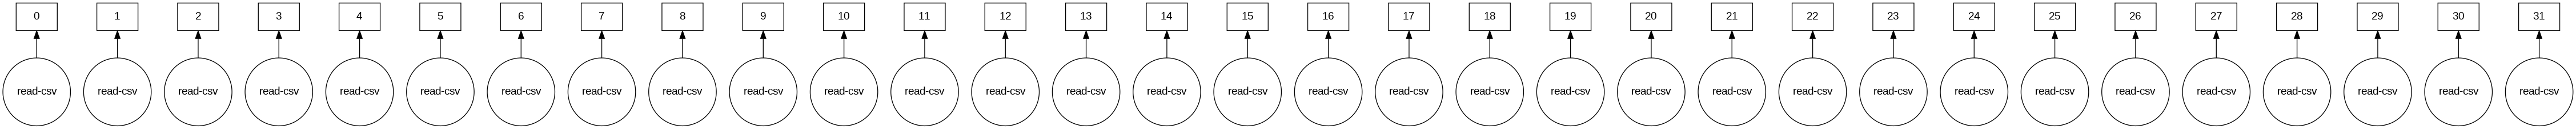

In [ ]:
df.visualize()

In [ ]:
file_size = os.path.getsize(parking_violation_csv)
print("File Size is :", file_size/(1000*1000*1000), "Gigs")

File Size is : 2.086913576 Gigs


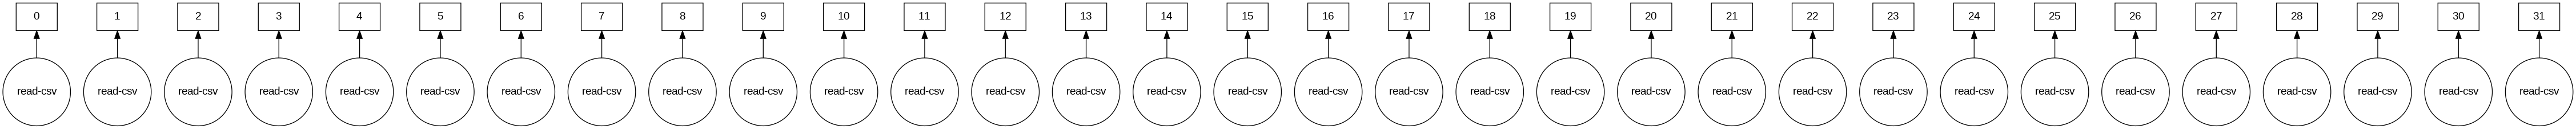

In [ ]:
df.visualize()

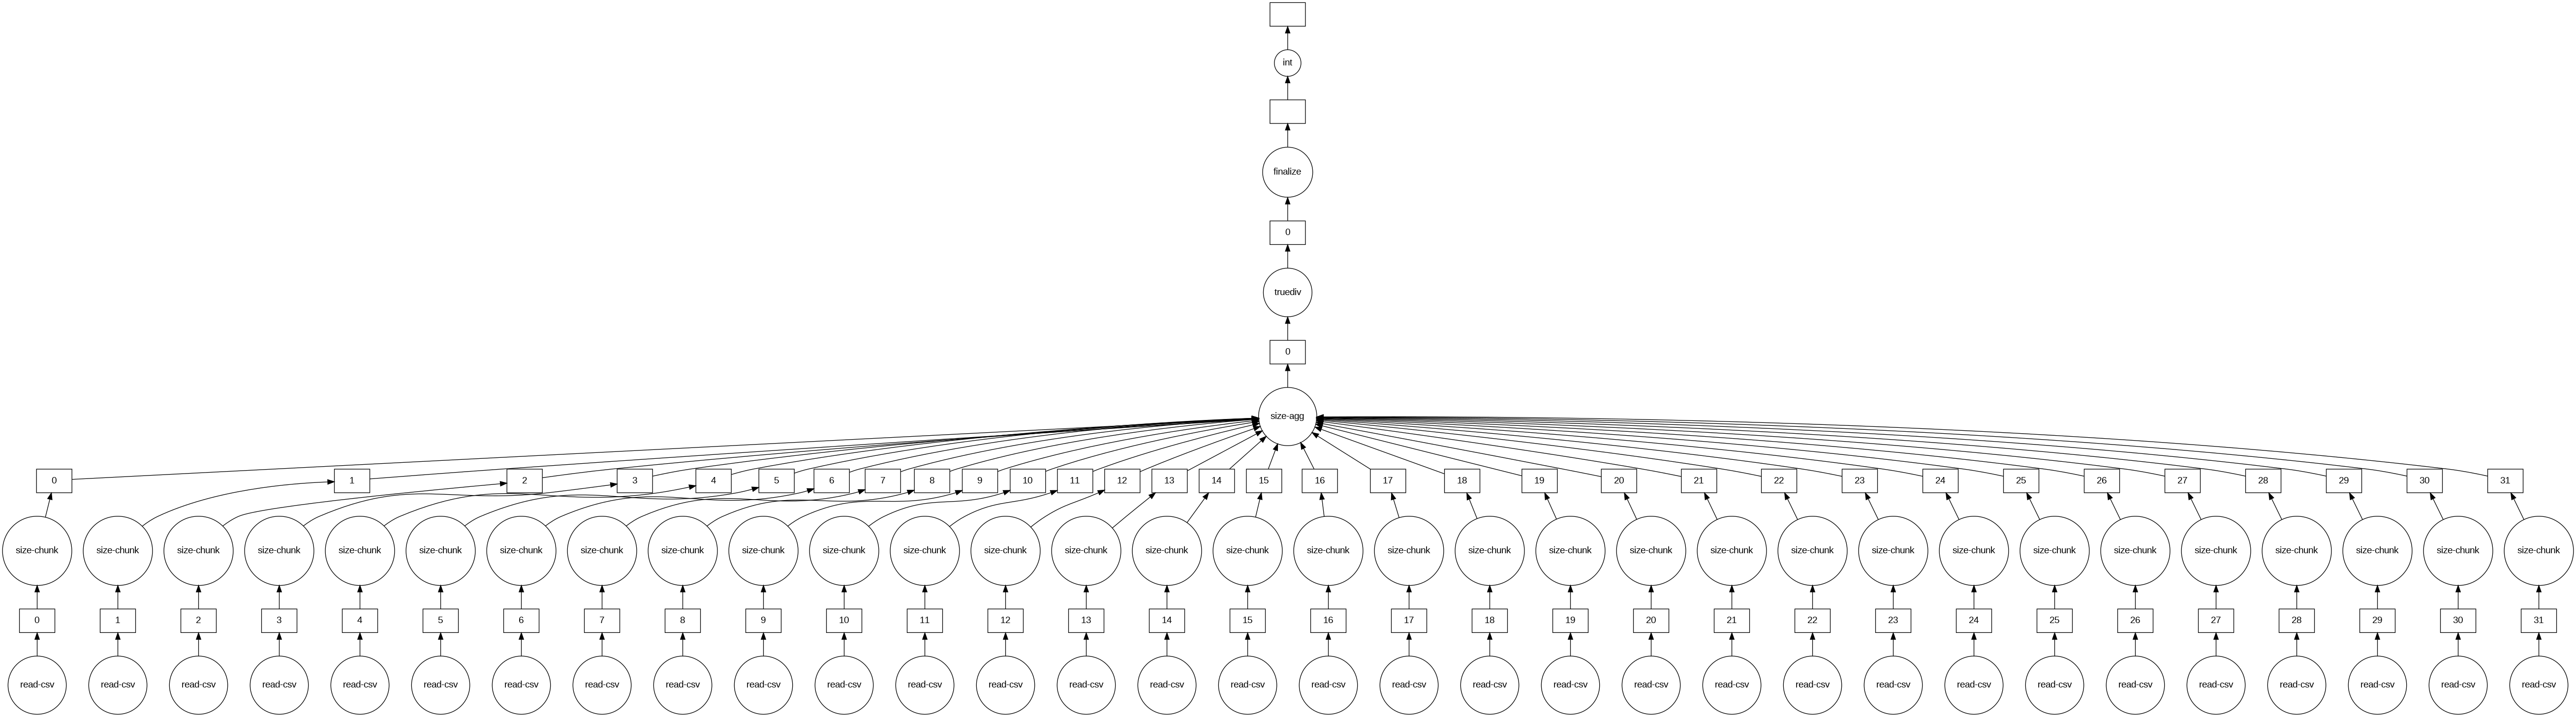

In [ ]:
df.shape[0].visualize()

**note that**
- _metadata_ are shown in the frame instead of data sample
- _syntax_ is pretty similar to Pandas API
- _# partitions_  is the number of splits used to separate the main dataset. The optimal number is decided by the scheduler that split Pandas DataFrame into smaller chuncks. In this case each partitions is ~64MB (i.e. Dataset size/npartitions = 2GB/33). If we have one worker, Dask will cycle to each partition one at time.
- _data types_ are reported under each column name (similary to describe method in Pandas, however performed through random sampling because data scattered across multiple physical machines). Good practice is to explicit data types instead relying on Dask's inference (store in binary format ideally, see links to Write and Read Parquet).
- _Dask Name_ reports the name of the DAG (i.e. from-delayed)
- _# tasks_ is the number of nodes in the DAG. You can think of a task as a Python function and in this case each partition operates 3 tasks: 1) reading the raw data, 2) splitting the data in appropriate blocks and, 3) initialazing the DataFrame object. Every task comes with some overhead (between 200μs and 1ms).

<img src="https://storage.googleapis.com/public_colab_images/ai5/dask_partitions.PNG" width="600">
<br>

Partition process from **Data Science with Python and Dask**

**Want to know more?**
- [Best Practices](https://docs.dask.org/en/latest/best-practices.html)
- [Write and Read Parquet](https://examples.dask.org/dataframes/01-data-access.html)

Next lets display some data in the dataframe

In [ ]:
# Display the top rows
df.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,5092469481,GZH7067,NY,PAS,07/10/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
1,5092451658,GZH7067,NY,PAS,07/08/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
2,4006265037,FZX9232,NY,PAS,08/23/2016,5,SUBN,FORD,V,0,...,BK,NaN,2004,NaN,0,NaN,BUS LANE VIOLATION,NaN,NaN,NaN
3,8478629828,66623ME,NY,COM,06/14/2017,47,REFG,MITSU,T,10610,...,WH,NaN,2007,NaN,0,04,47-Double PKG-Midtown,NaN,NaN,NaN
4,7868300310,37033JV,NY,COM,11/21/2016,69,DELV,INTER,T,10510,...,WHITE,NaN,2007,NaN,0,31 6,69-Failure to Disp Muni Recpt,NaN,NaN,NaN


### **Check data quality issues**

In [ ]:
# Count missing values
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Date First Observed    int64
Violation Time           ...
dtype: int64
Dask Name: dataframe-sum-agg, 4 graph layers

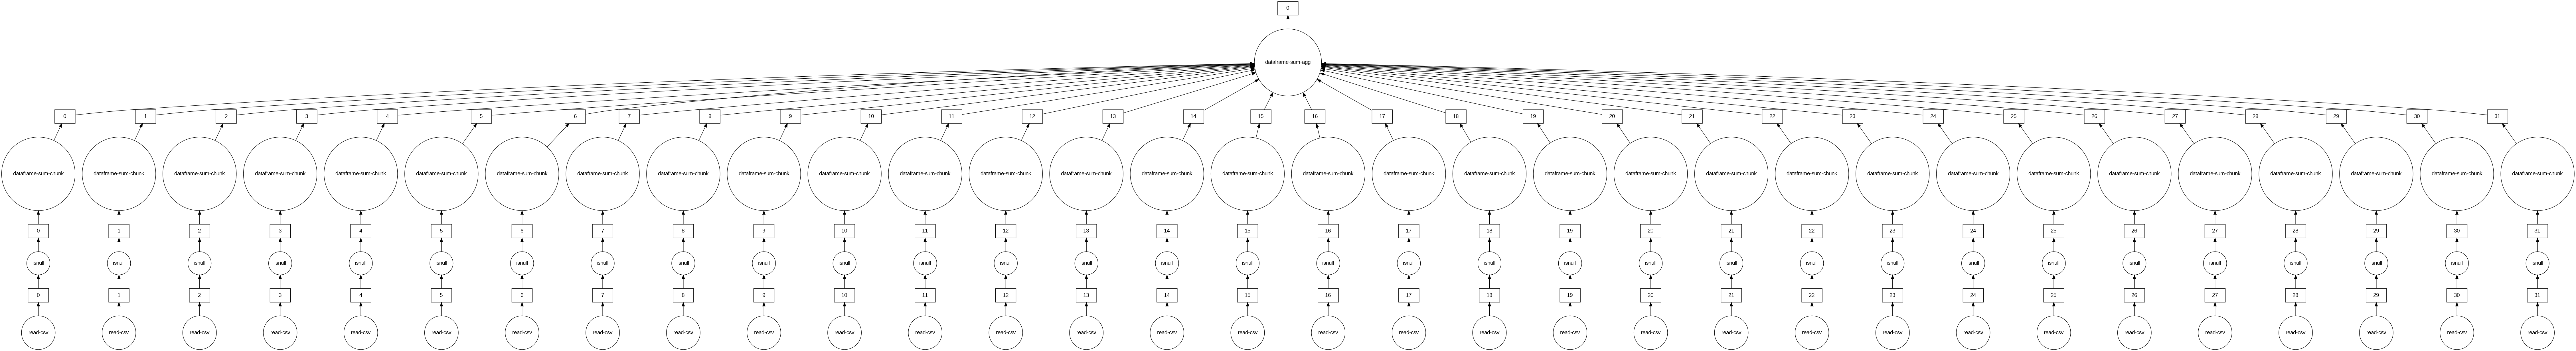

In [ ]:
missing_values.visualize()

**note that**
- _dask object_ created is a series containing _metadata_ and _syntax_ is pretty similar to Pandas API
- _processing hasn't be completed_ yet, instead Dask prepared a DAG stored in the missing values variable (advantage of building graph quickly without need to wait for computation)
- _# tasks_ increased because have been added 2 tasks (i.e. check missing values and sum) for each of the 33 partitions as well as a final addition to aggregate the results among all the partitions for a total of 166 = [(66+1)+99]

In [ ]:
df.npartitions
g = missing_values.__dask_graph__()
len(g)

97

In [ ]:
# Calculate percent missing values
df_size =  df.index.size
missing_count = ((missing_values /df_size)*100)
missing_count

Dask Series Structure:
npartitions=1
Date First Observed    float64
Violation Time             ...
dtype: float64
Dask Name: mul, 9 graph layers

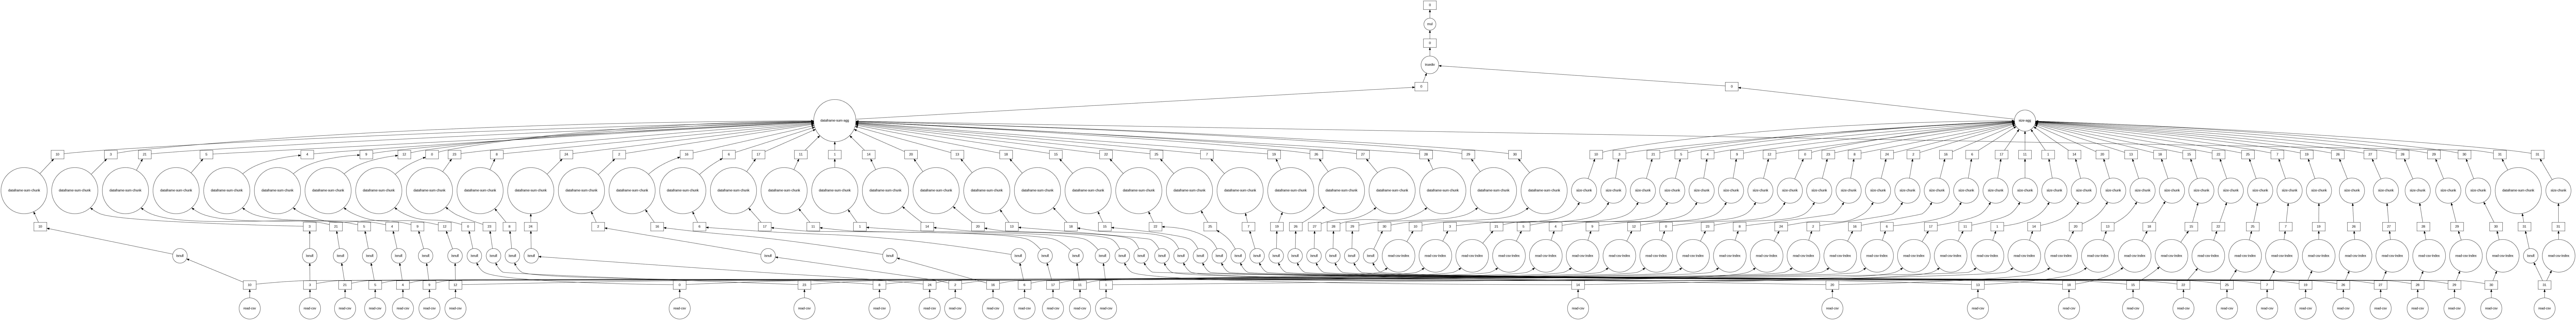

In [ ]:
missing_count.visualize()

**note that**

- _dask object_ created is a series and computation hasn't be completed yet
- _df.index.size_ is a dask object _dask.dataframe.core.Scalar_ . You cannot access its value/lenght directely like you would do with a list (e.g. len()). It would go against the whole idea of dask (i.e. read all the dataset)
- _# tasks_ increased because we have  added: 2 tasks per partition (2*33) for the index() plus one aggregation and  2 tasks (i.e. division and multiplication).
166+67+2 = 235
- _data type_ has changed from int64 to float64. Dask automatically converted it once the datatype at the output might not match the input after the division

In [ ]:
# Run computations using compute method
with ProgressBar():
    missing_count_percent = missing_count.compute()
missing_count_percent

[###############################         ] | 79% Completed | 68.10 s

/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[########################################] | 100% Completed | 75.75 s


Summons Number                         0.000000
Plate ID                               0.006739
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000000
Violation Code                         0.000000
Vehicle Body Type                      0.395361
Vehicle Make                           0.676199
Issuing Agency                         0.000000
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    19.183510
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        19.093212
Issuer Squad                          19.101506
Violation Time                         0.000583
Time First Observed                   92

In [ ]:
# Run computations using compute method
missing_count_percent = missing_count.compute()
missing_count_percent

KeyboardInterrupt: ignored

In [ ]:
type(missing_count_percent)

pandas.core.series.Series

**note that**

- _.compute() method_ is necessary to run the actions embedded in each node of the DAG
- The _results_ of the compute method are stored into a Pandas Series
- _ProgressBar()_ is a wrapper to keep track of running tasks. It shows completed work
- _from a quick visual inspection_ we can see that are columns that are incomplete and we should drop

### **Drop Columns**

In [ ]:
# Filter sparse columns(greater than 60% missing values) and store them
columns_to_drop = missing_count_percent[missing_count_percent > 60].index
columns_to_drop

Index(['Time First Observed', 'Intersecting Street', 'Violation Legal Code',
       'Unregistered Vehicle?', 'Meter Number',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

In [ ]:
# Drop sparse columns
with ProgressBar():
  df_dropped = df.drop(columns_to_drop.to_list(), axis=1).compute()

[#####################################   ] | 93% Completed | 60.55 s

/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[########################################] | 100% Completed | 61.27 s


**note that**

- _use Pandas Series_ to drop columns in Dask DataFrames because each partition is a Pandas DataFrame
- In the case the Series is made available to all threads, in a cluster it would be serialized and brodcast to all the worker nodes
- _.persit() method_ allows to store in memory intermediate computations so they can be reused.

## **<font color="#A41034">Visualizing DAGs</font>**


### **DAG with one node with dependency**

In [ ]:
def increment(i):
    return i + 1

x = increment(5)
print(x)
x = delayed(increment)(5)
print(x)
print(x.compute())

6
Delayed('increment-b184911b-5edf-41fd-9bc2-b78533b18133')
6


z Delayed('add-9fac8ad4-810f-4e98-8612-93670cfc83ea') x Delayed('increment-8271dd83-0914-428f-994b-3fe6446d16a5') y Delayed('increment-2c06e2b0-3fa9-421e-b63b-d256f1345ff6')


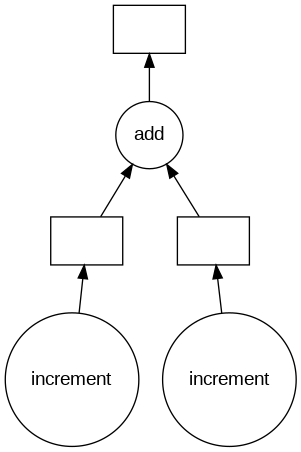

In [ ]:
def increment(i):
    return i + 1

def add(x, y):
    return x + y

# wrap functions within delayed object and chain
x = delayed(increment)(1)
y = delayed(increment)(2)
z = delayed(add)(x, y)

print("z",z, "x",x,"y",y)
# visualize the DAG
z.visualize()

In [ ]:
def increment(i):
    return i + 1

def add(x, y):
    return x + y

x = increment(1)
y = increment(2)
z1 = delayed(add)(x, y)
z = z1 + x
#z = add(x, y)
print("z",z, "x",x,"y",y)


z Delayed('add-1445e8acf9efb7f7c2194689cced6352') x 2 y 3


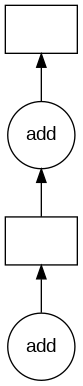

In [ ]:
z.visualize()

In [ ]:
# show the result
z.compute()

7

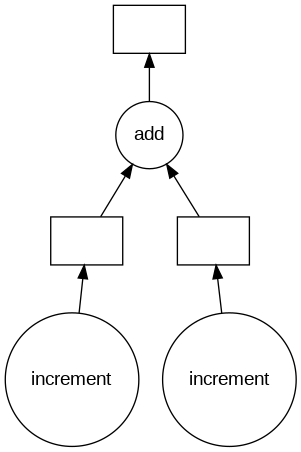

In [ ]:
@dask.delayed
def increment(i):
    return i + 1

@dask.delayed
def add(x, y):
    return x + y



x = increment(1)
y = increment(2)
#z = delayed(add)(x, y)
z = add(x, y)
z.visualize()

In [ ]:
dask.compute(add(increment(1),increment(2)))

(5,)

**note that**
- _to build a node_ wrap the function with the delayed object and then pass the arguments of the function. You could also use a decorators (see example).
- _circles_ symbolize function and computations while _squares_ intermediate or final result
- _incoming arrows_ represent dependecies. The _increment_ function do not have any dependency while _add_ function has two. Thus, add function has to wait until objects x and y have been calculated
- functions without dependencies can be computed independentely and a worker can be assigned to each one of them
- _use method .visualize()_ on the last node with dependencies to peak at the DAG
- _Dask does not compute the DAG_ . Use the method .compute() on the last node to see the result

### **DAG with more than one node with dependencies**

- we are going to build a more complex DAG with two layers:
    - layer1 is built by looping over a list of data using a list comprehension to create dask delayed objects as "leaves" node. This layer combines the previously created function increment with the values in the list, then use the built in function sum to combine the results;
    - layer2 is built looping on each object created in layer1 and

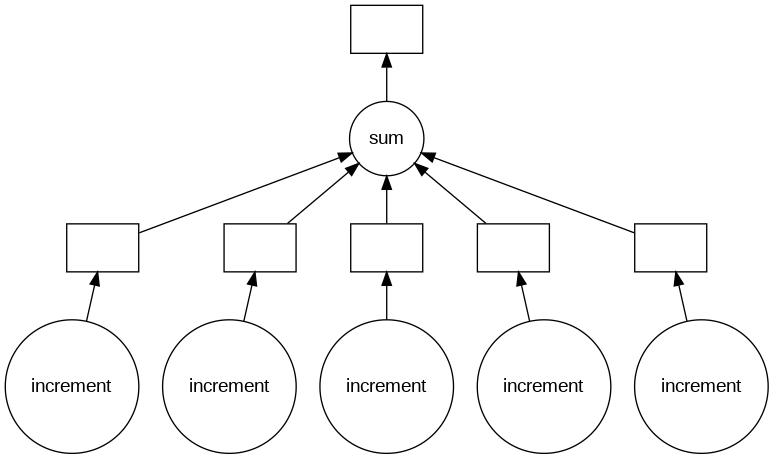

In [ ]:
data = [1, 2, 3, 4, 5]

# compile first layer and visualize
layer1 = [delayed(increment)(i) for i in data]
total1 = delayed(sum)(layer1)
total1.visualize()

In [ ]:
layer1 = [ increment(i) for i in data]
layer2 = sum(layer1)
layer2



Delayed('add-ff8834fd8edf5a5ed8e116031d8ef613')

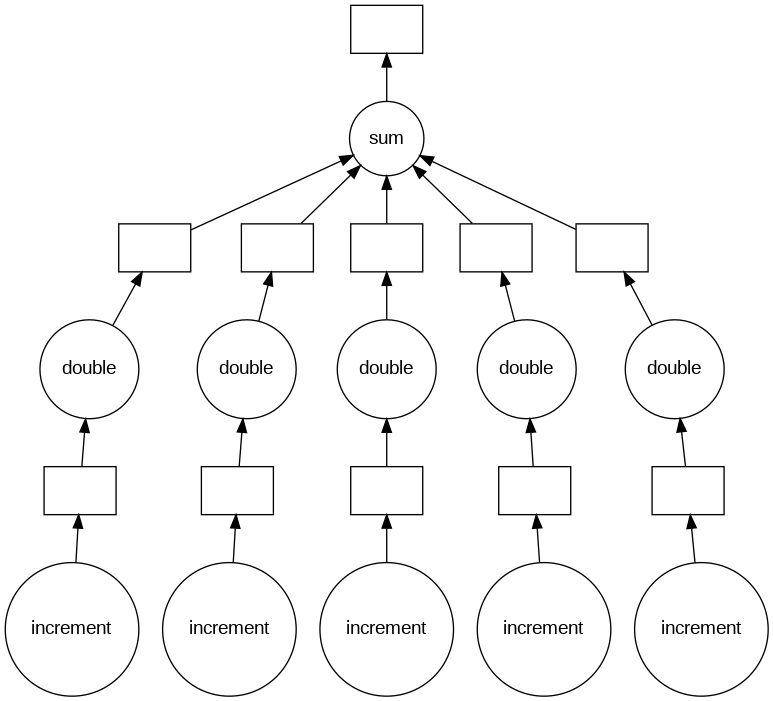

In [ ]:
def double(x):
    return x * 2

# compile second layer and visualize
layer2 = [delayed(double)(j) for j in layer1]
total2 = delayed(sum)(layer2)#.persist()
total2.visualize()

In [ ]:
z = total2.compute()
#z = total2
z

40

**note that**
- _built in function_
- _persistent_ using .persist() and it will be represented as a rectangle in the graph

## **<font color="#A41034">Example: Build Dask DataFrame</font>**


Let us build a Dask DataFrame from a Pandas DataFrame

In [ ]:
# Create lists of actions
action_IDs = [i for i in range(0,10)]
action_description = ['Clean dish', 'Dress up', 'Wash clothes','Take shower',
                      'Groceries','Take shower','Dress up','Gym','Take shower','Movie']
action_date = ['2022-9-16', '2022-9-16', '2022-9-16', '2022-9-16', '2022-9-16',
               '2022-9-17', '2022-9-17', '2022-9-17', '2022-9-17', '2022-9-17']

# store list into Pandas DataFrame
action_pandas_df = pd.DataFrame({'Action ID': action_IDs,
                                 'Action Description': action_description,
                                 'Date': action_date},
                                 columns=['Action ID', 'Action Description', 'Date'])
action_pandas_df

,Action ID,Action Description,Date
0,0,Clean dish,2022-9-16
1,1,Dress up,2022-9-16
2,2,Wash clothes,2022-9-16
3,3,Take shower,2022-9-16
4,4,Groceries,2022-9-16
5,5,Take shower,2022-9-17
6,6,Dress up,2022-9-17
7,7,Gym,2022-9-17
8,8,Take shower,2022-9-17
9,9,Movie,2022-9-17


In [ ]:
# Convert Pandas DataFrame to a Dask DataFrame
action_dask_df = dd.from_pandas(action_pandas_df, npartitions=3)


In [ ]:
action_dask_df

,Action ID,Action Description,Date
npartitions=3,,,
0,int64,object,object
4,...,...,...
7,...,...,...
9,...,...,...


In [ ]:
action_dask_df.head()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:8110: UserWarning: Insufficient elements for `head`. 5 elements requested, only 4 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,Action ID,Action Description,Date
0,0,Clean dish,2022-9-16
1,1,Dress up,2022-9-16
2,2,Wash clothes,2022-9-16
3,3,Take shower,2022-9-16


In [ ]:
# Info Dask Dataframe
print('<index where df has been split>', action_dask_df.divisions)
print('<# partitions>', action_dask_df.npartitions)

<index where df has been split> (0, 4, 7, 9)
<# partitions> 3


In [ ]:
# Count rows per partition
count_perpartition = action_dask_df.map_partitions(len)
count_perpartition

Dask Series Structure:
npartitions=3
0    int64
4      ...
7      ...
9      ...
dtype: int64
Dask Name: len, 2 graph layers

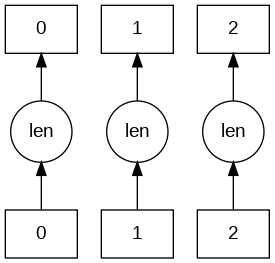

In [ ]:
count_perpartition.visualize()

In [ ]:
count_perpartition.compute()

0    4
1    3
2    3
dtype: int64

In [ ]:
# Filter entries in dask dataframe
print('\n <number of entries in each partition after filtering>')
action_filtered = action_dask_df[action_dask_df['Action Description'] != 'Take shower']
print(action_filtered.map_partitions(len).compute())

print('\n <double check number of entries after reorganizing dataframe in one partition>')
action_filtered_reduced = action_filtered.repartition(npartitions=1)
print(action_filtered_reduced.map_partitions(len).compute())


 <number of entries in each partition after filtering>
0    3
1    2
2    2
dtype: int64

 <double check number of entries after reorganizing dataframe in one partition>
0    7
dtype: int64


## **<font color="#A41034">Compute Mushroom dataset metrics</font>**


#### Load image file paths

In [ ]:
mushrooms_data_path = os.path.join("datasets","mushrooms","**/*")

# Get a list of paths to all images
image_files = glob(mushrooms_data_path)
print("Number of file:",len(image_files))

Number of file: 1643


#### Compute Metrics using Dask

In [ ]:
image_width = 224
image_height = 224
num_channels = 3

@dask.delayed
def read_resize_image(file_path):
  # read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Resize image
  image = cv2.resize(image, (image_width,image_height), interpolation = cv2.INTER_AREA)

  return image

In [ ]:
lazy_loaded_images = [read_resize_image(path) for path in image_files]

image_arrays = [dask.array.from_delayed(img,dtype=np.uint8,shape=(image_height, image_width, num_channels)) for img in lazy_loaded_images]
all_images_dask = dask.array.stack(image_arrays, axis=0)

In [ ]:
lazy_loaded_images[0:2]

[Delayed('read_resize_image-76366b0e-c34e-495c-8b00-e8bdb37f6737'),
 Delayed('read_resize_image-c36e3332-0be0-4fa3-ab1d-9049b636d942')]

In [ ]:
all_images_dask

dask.array<stack, shape=(1643, 224, 224, 3), dtype=uint8, chunksize=(1, 224, 224, 3), chunktype=numpy.ndarray>

In [ ]:
start_time = time.time()
dask_metrics = {}
#mean = all_images_dask.mean(axis=(0,1, 2)).compute()
#stdev = all_images_dask.std(axis=(0,1, 2)).compute()
mean, stdev = dask.compute(all_images_dask.mean(axis=(0,1, 2)), all_images_dask.std(axis=(0,1, 2)))
print("mean:", mean)
print("stdev:", stdev)
dask_metrics["mean"] = mean
dask_metrics["stdev"] = stdev
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

mean: [146.99406773 132.88568588 115.44954795]
stdev: [77.3312431  76.97780099 82.08591924]
Execution time (mins) 0.2283306916554769


#### Compute Metrics using Numpy

Using numpy we load all the images and compute the dataset metrics. This only works if we can load all images into memory. Since our dataset is small this is possible

In [ ]:
all_images_numpy = []

start_time = time.time()
for file_path in image_files:
  #print(file_path)
  # read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Resize image
  image = cv2.resize(image, (image_width,image_height), interpolation = cv2.INTER_AREA)
  # Train x
  all_images_numpy.append(image)

# Convert to numpy array
all_images_numpy = np.asarray(all_images_numpy)
numpy_metrics = {}
mean = np.mean(all_images_numpy, axis=(0,1, 2))
print("mean:", mean)
stdev = np.std(all_images_numpy, axis=(0,1, 2))
print("stdev:", stdev)
numpy_metrics["mean"] = mean
numpy_metrics["stdev"] = stdev
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

mean: [146.99406773 132.88568588 115.44954795]
stdev: [77.3312431  76.97780099 82.08591924]
Execution time (mins) 0.809571897983551
